<a href="https://colab.research.google.com/github/Sireesiru/Cryo-EM-Ultrastructures/blob/main/Bacterial%20Envelope%20Thickness%20tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.3 MB/s eta 0:00:00


In [4]:
!git clone https://github.com/Sireesiru/Cryo-EM-Ultrastructures.git

Cloning into 'Cryo-EM-Ultrastructures'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 67 (delta 10), reused 22 (delta 4), pack-reused 31 (from 2)
Receiving objects: 100% (67/67), 345.27 MiB | 13.82 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (42/42), done.


# **Thickness calculation for single test set image**

Bacterium 1: eccentricity=0.87, mode=PCA-based
Bacterium 2: eccentricity=0.88, mode=PCA-based
Bacterium 3: eccentricity=0.96, mode=PCA-based


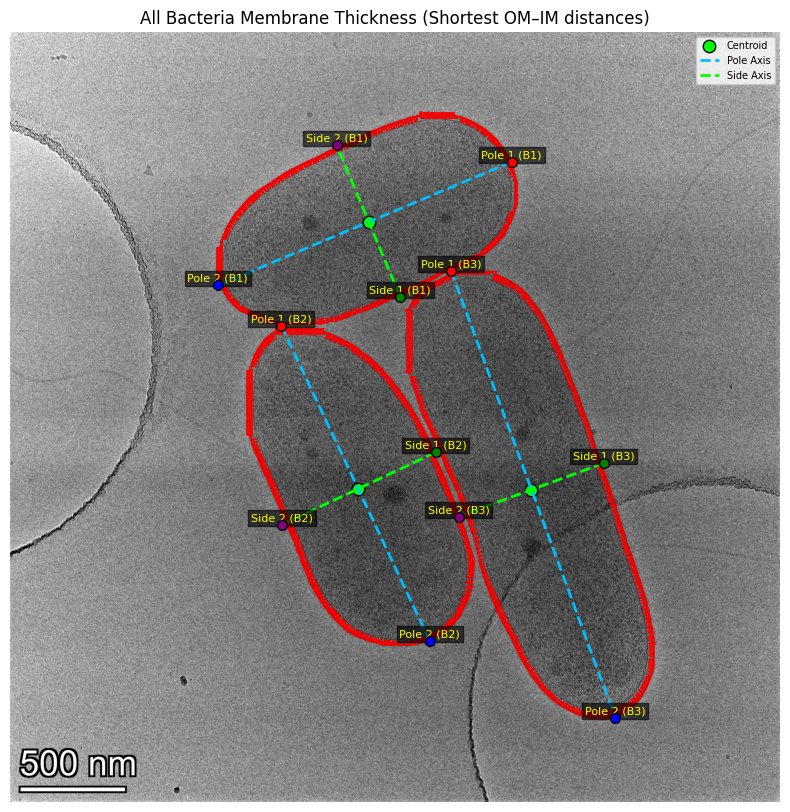


Combined Thickness measurements:


,Bacterium,Distance (px),Distance (nm),Angle (deg)
0,1,25.632011,23.032925,0.000000
1,1,25.632011,23.032925,0.000000
2,1,26.000000,23.363600,0.064375
3,1,26.000000,23.363600,0.064375
4,1,26.400758,23.723721,0.128689



Per-cell Metrics:


,Bacterium,Mean Thickness (nm),Variance (nm^2),Std (nm),CV,Pole Mean,Side Mean,Pole-Side Diff
0,1,21.952485,23.545007,4.852320,0.221037,21.951874,21.875866,0.076008
1,2,25.982118,7.828583,2.797960,0.107688,25.812172,25.394040,0.418132
2,3,25.688557,20.832765,4.564292,0.177678,27.556067,23.809887,3.746180



Thickness at requested angles:


,Bacterium,Distance (px),Distance (nm),Angle (deg),Target_Angle
0,1,25.632011,23.032925,0.000000,0
1,1,32.000000,28.755200,36.034841,36
2,1,26.400758,23.723721,71.977789,72
3,1,25.298221,22.732982,107.952328,108
4,1,29.732137,26.717299,143.973540,144
5,1,12.041595,10.820577,180.008190,180
6,1,12.000000,10.783200,216.005299,216
7,1,22.825424,20.510926,251.948614,252
8,1,17.088007,15.355284,288.046642,288
9,1,21.260292,19.104498,324.005389,324


In [7]:
### V1 METHOD (shortest distance) with PCA poles/sides + circular override + per-cell metrics ###

import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.spatial
import pandas as pd
import os
from ultralytics import YOLO

# =========================
# Utility: PCA axis finder
# =========================
def pca_axes(points):
    pts = points - points.mean(axis=0)
    cov = np.cov(pts.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, order]
    return eigvecs  # [0]=major axis, [1]=minor axis

# =========================
# Processing + plotting for one image
# =========================
def process_and_draw_all(om_masks, im_masks, image_rgb, save_prefix, N=10000):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(image_rgb)
    ax.axis('off')
    ax.set_title("All Bacteria Membrane Thickness (Shortest OM–IM distances)")

    all_dfs = []
    metrics_list = []
    angles_dfs = []
    used_ims = set()
    target_angles = [0,36,72,108,144,180,216,252,288,324]

    for bid, om_mask_bin in enumerate(om_masks, start=1):
        # --- match OM to best IM ---
        best_overlap, best_im_idx = 0, None
        for j, im_mask_bin in enumerate(im_masks):
            if j in used_ims: continue
            overlap = np.sum((om_mask_bin>0) & (im_mask_bin>0))
            if overlap > best_overlap:
                best_overlap, best_im_idx = overlap, j
        if best_im_idx is None:
            continue
        used_ims.add(best_im_idx)

        # --- contours ---
        om_contour = max(cv2.findContours(om_mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0],
                         key=cv2.contourArea).reshape(-1,2).astype(np.float32)
        im_contour = max(cv2.findContours(im_masks[best_im_idx], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0],
                         key=cv2.contourArea).reshape(-1,2).astype(np.float32)

        # --- centroid ---
        M = cv2.moments(im_contour)
        cent = np.array([M["m10"]/M["m00"], M["m01"]/M["m00"]], dtype=np.float32)
        ax.scatter(cent[0], cent[1], c='lime', s=80, edgecolors='black', label='Centroid' if bid==1 else "")

        # ---- Uniform Sampling along OM ----
        diffs = np.diff(om_contour, axis=0, append=om_contour[:1])
        seg_lens = np.hypot(diffs[:,0], diffs[:,1])
        cumlen = np.cumsum(seg_lens)
        total = cumlen[-1]
        targets = np.linspace(0, total, N, endpoint=False)
        sampled_om_points = np.array([om_contour[np.searchsorted(cumlen, t)] for t in targets])

        # ---- PCA or Circular override for poles/sides ----
        if len(im_contour) >= 5:
            (x,y),(MA,ma),angle = cv2.fitEllipse(im_contour)
            eccentricity = np.sqrt(1 - (min(MA,ma)**2 / max(MA,ma)**2))
        else:
            eccentricity = 1.0

        if eccentricity < 0.7:  # circular → orthogonal axes
            major_axis = np.array([1.0, 0.0])
            minor_axis = np.array([0.0, 1.0])
            mode = "circular override"
        else:  # elongated → PCA
            eigvecs = pca_axes(om_contour)
            major_axis, minor_axis = eigvecs[:,0], eigvecs[:,1]
            mode = "PCA-based"

        print(f"Bacterium {bid}: eccentricity={eccentricity:.2f}, mode={mode}")

        # ---- Pole and Side points ----
        projections_major = np.dot(om_contour - cent, major_axis)
        projections_minor = np.dot(om_contour - cent, minor_axis)

        p1 = cent + major_axis * projections_major.min()
        p2 = cent + major_axis * projections_major.max()
        s1 = cent + minor_axis * projections_minor.min()
        s2 = cent + minor_axis * projections_minor.max()

        # ---- Measurements + rays ----
        measurements = []
        tree = scipy.spatial.cKDTree(im_contour)
        for pt in sampled_om_points:
            pt_f = pt.astype(float)
            dist, idx = tree.query(pt_f)
            imp = im_contour[idx]

            # angle relative to pole axis
            vec_pt_cent = cent - pt_f
            cos_angle = np.dot(vec_pt_cent, major_axis) / (np.linalg.norm(vec_pt_cent)+1e-8)
            angle = np.arccos(np.clip(cos_angle, -1, 1))
            if np.dot(pt_f - cent, minor_axis) < 0:
                angle = 2*np.pi - angle

            measurements.append({"OM": pt_f, "IM": imp, "Thickness": dist, "Angle": angle})
            ax.plot([pt_f[0], imp[0]], [pt_f[1], imp[1]], color='red', lw=0.5, alpha=0.3)

        # ---- Normalize angles ----
        measurements.sort(key=lambda x: x["Angle"])
        if not measurements:
            print(f"Bacterium {bid}: No measurements calculated, skipping.")
            continue
        pole1_angle = measurements[0]["Angle"]
        for m in measurements:
            m["Angle"] = (m["Angle"] - pole1_angle) % (2*np.pi)

        # ---- Axes lines ----
        ax.plot([p1[0], cent[0], p2[0]], [p1[1], cent[1], p2[1]], 'deepskyblue', ls='--', lw=2, label="Pole Axis" if bid==1 else "")
        ax.plot([s1[0], cent[0], s2[0]], [s1[1], cent[1], s2[1]], 'lime', ls='--', lw=2, label="Side Axis" if bid==1 else "")

        # ---- Special points ----
        color_map = {"Pole 1": ('red', p1), "Pole 2": ('blue', p2),
                     "Side 1": ('green', s1), "Side 2": ('purple', s2)}
        for label,(col,pt) in color_map.items():
            ax.scatter(pt[0], pt[1], c=col, s=50, edgecolors='black', zorder=5)
            ax.text(pt[0], pt[1]-20, f"{label} (B{bid})", fontsize=8, color='yellow',
                    ha='center', bbox=dict(facecolor='black', alpha=0.6, pad=2))

        # ---- DataFrame ----
        distances = [m["Thickness"] for m in measurements]
        angles_deg = [np.degrees(m["Angle"]) for m in measurements]
        df = pd.DataFrame({
            "Bacterium": [bid]*len(distances),
            "Distance (px)": distances,
            "Distance (nm)": [d * 0.8986 for d in distances],
            "Angle (deg)": angles_deg
        })
        all_dfs.append(df)

        # ---- Per-cell metrics ----
        mean_t = df["Distance (nm)"].mean()
        var_t  = df["Distance (nm)"].var()
        std_t  = df["Distance (nm)"].std()
        cv_t   = std_t / mean_t if mean_t>0 else np.nan

        poles = df[(df["Angle (deg)"] < 20) | (df["Angle (deg)"] > 340) |
                   ((df["Angle (deg)"] > 160) & (df["Angle (deg)"] < 200))]
        sides = df[((df["Angle (deg)"] > 70) & (df["Angle (deg)"] < 110)) |
                   ((df["Angle (deg)"] > 250) & (df["Angle (deg)"] < 290))]
        mean_poles = poles["Distance (nm)"].mean()
        mean_sides = sides["Distance (nm)"].mean()

        metrics_list.append({
            "Bacterium": bid,
            "Mean Thickness (nm)": mean_t,
            "Variance (nm^2)": var_t,
            "Std (nm)": std_t,
            "CV": cv_t,
            "Pole Mean": mean_poles,
            "Side Mean": mean_sides,
            "Pole-Side Diff": mean_poles - mean_sides if (not np.isnan(mean_poles) and not np.isnan(mean_sides)) else np.nan
        })

        # ---- Target angles ----
        for target in target_angles:
            idx = (df["Angle (deg)"] - target).abs().idxmin()
            # Create a new DataFrame row from the Series and add the column
            row_df = df.loc[[idx]].copy() # Use [[idx]] to keep it as a DataFrame
            row_df['Target_Angle'] = target
            angles_dfs.append(row_df)


    ax.legend(loc='upper right', fontsize=7)
    save_img = f"{save_prefix}_thickness.png"
    plt.savefig(save_img, dpi=150, bbox_inches="tight")
    plt.show()

    combined_df = pd.concat(all_dfs, ignore_index=True)
    metrics_df = pd.DataFrame(metrics_list)
    # Concatenate the list of DataFrames into a single DataFrame
    angles_df = pd.concat(angles_dfs, ignore_index=True)

    ## Print results
    print("\nCombined Thickness measurements:")
    display(combined_df.head(5))
    print("\nPer-cell Metrics:")
    display(metrics_df)
    print("\nThickness at requested angles:")
    display(angles_df)

    return combined_df, metrics_df, angles_df

# =========================
# Main single-image run
# =========================
model_path = "/content/Cryo-EM-Ultrastructures/models/best_thickness.pt"
image_path = '/content/Cryo-EM-Ultrastructures/Datasets/Thickness/59_Camera Falcon 2320 Falcon_MOPSsuc.png'

# Prepare output prefix
base = os.path.splitext(os.path.basename(image_path))[0]
output_folder = os.path.dirname(image_path)
save_prefix = os.path.join(output_folder, base)

# Load image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_height, img_width = image_rgb.shape[:2]

# Run YOLO
model = YOLO(model_path)
results = model(image_rgb, verbose=False)[0]
masks = results.masks.data.cpu().numpy()
class_ids = results.boxes.cls.cpu().numpy().astype(int)

# Split OM & IM masks
om_masks, im_masks = [], []
for i, mask in enumerate(masks):
    resized = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
    binary = (resized > 0.5).astype(np.uint8) * 255
    if class_ids[i] == 1:
        om_masks.append(binary)
    elif class_ids[i] == 0:
        im_masks.append(binary)

# Process
combined_df, metrics_df, angles_df = process_and_draw_all(om_masks, im_masks, image_rgb, save_prefix, N=10000)

# CSV saving (disabled)
combined_df.to_csv(f"{save_prefix}_thickness.csv", index=False)
metrics_df.to_csv(f"{save_prefix}_metrics.csv", index=False)
angles_df.to_csv(f"{save_prefix}_angles.csv", index=False)

## **Repeat thickness and angles for all images within the test folder**

In [10]:
####### Repeat genrating results for all files in the test folder ###############

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from ultralytics import YOLO
import scipy.spatial

# =========================
# Utility: line intersections with OM contour
# =========================
def line_intersections_with_contour(centroid, direction, contour):
    intersections = []
    dir_vec = direction / (np.linalg.norm(direction)+1e-8)
    for i in range(len(contour)):
        p1 = contour[i]
        p2 = contour[(i+1) % len(contour)]
        A = np.array([p2 - p1, -dir_vec]).T
        b = centroid - p1
        if np.linalg.matrix_rank(A) == 2:
            t, u = np.linalg.lstsq(A, b, rcond=None)[0]
            if 0 <= t <= 1:
                inter = p1 + t*(p2 - p1)
                intersections.append(inter)
    return intersections

# =========================
# Processing + plotting for one image
# =========================
def process_and_draw_all(om_masks, im_masks, image_rgb, save_path, save_csv, save_angles_csv, N=10000):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(image_rgb)
    ax.axis('off')
    ax.set_title("All Bacteria Membrane Thickness (Shortest OM–IM distances)")

    all_dfs = []   # store per-bacterium DataFrames
    angles_dfs = []
    used_ims = set()
    target_angles = [0,36,72,108,144,180,216,252,288,324]

    for bid, om_mask_bin in enumerate(om_masks, start=1):
        # --- match OM to best IM ---
        best_overlap, best_im_idx = 0, None
        for j, im_mask_bin in enumerate(im_masks):
            if j in used_ims: continue
            overlap = np.sum((om_mask_bin>0) & (im_mask_bin>0))
            if overlap > best_overlap:
                best_overlap, best_im_idx = overlap, j
        if best_im_idx is None:
            continue
        used_ims.add(best_im_idx)

        # --- contours ---
        om_contour = max(cv2.findContours(om_mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0],
                         key=cv2.contourArea).reshape(-1,2).astype(np.float32)
        im_contour = max(cv2.findContours(im_masks[best_im_idx], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0],
                         key=cv2.contourArea).reshape(-1,2).astype(np.float32)

        # --- centroid ---
        M = cv2.moments(im_contour)
        cent = np.array([M["m10"]/M["m00"], M["m01"]/M["m00"]], dtype=np.float32)
        ax.scatter(cent[0], cent[1], c='lime', s=80, edgecolors='black', label='Centroid' if bid==1 else "")

        # --- draw OM & IM ---
        ax.plot(om_contour[:,0], om_contour[:,1], 'y-', alpha=0.8, label='OM Contour' if bid==1 else "")
        ax.plot(im_contour[:,0], im_contour[:,1], 'b-', alpha=0.8, label='IM Contour' if bid==1 else "")

        # ---- Uniform Sampling along OM ----
        diffs = np.diff(om_contour, axis=0, append=om_contour[:1])
        seg_lens = np.hypot(diffs[:,0], diffs[:,1])
        cumlen = np.cumsum(seg_lens)
        total = cumlen[-1]
        targets = np.linspace(0, total, N, endpoint=False)
        sampled_om_points = np.array([om_contour[np.searchsorted(cumlen, t)] for t in targets])

        # ---- PCA for poles & sides ----
        om_centered = om_contour - np.mean(om_contour, axis=0)
        cov = np.cov(om_centered.T)
        eigvals, eigvecs = np.linalg.eigh(cov)
        idx = np.argsort(eigvals)[::-1]
        eigvecs = eigvecs[:, idx]

        pole_axis = eigvecs[:,0]
        side_axis = eigvecs[:,1]

        inter_pole = line_intersections_with_contour(cent, pole_axis, om_contour)
        inter_side = line_intersections_with_contour(cent, side_axis, om_contour)

        if len(inter_pole) >= 2:
            p1, p2 = inter_pole[0], inter_pole[-1]
        else:
            dists = np.linalg.norm(om_contour-cent, axis=1)
            p1, p2 = om_contour[np.argmax(dists)], om_contour[np.argmin(dists)]
        if len(inter_side) >= 2:
            s1, s2 = inter_side[0], inter_side[-1]
        else:
            s1, s2 = None, None

        # ---- Measurements + rays ----
        measurements = []
        tree = scipy.spatial.cKDTree(im_contour)
        unit_vector_pole1 = pole_axis / (np.linalg.norm(pole_axis)+1e-8)
        perpendicular_axis = side_axis

        for pt in sampled_om_points:
            pt_f = pt.astype(float)
            dist, idx = tree.query(pt_f)
            imp = im_contour[idx]

            vec_pt_cent = cent - pt_f
            cos_angle = np.dot(vec_pt_cent, unit_vector_pole1) / (np.linalg.norm(vec_pt_cent)+1e-8)
            angle = np.arccos(np.clip(cos_angle, -1, 1))
            if np.dot(pt_f - cent, perpendicular_axis) < 0:
                angle = 2*np.pi - angle

            measurements.append({"OM": pt_f, "IM": imp, "Thickness": dist, "Angle": angle})
            ax.plot([pt_f[0], imp[0]], [pt_f[1], imp[1]], color='red', lw=0.5, alpha=0.3)

        # ---- Sort & normalize angles ----
        measurements.sort(key=lambda x: x["Angle"])
        pole1_angle = measurements[0]["Angle"]
        for m in measurements:
            m["Angle"] = (m["Angle"] - pole1_angle) % (2*np.pi)

        # ---- Cyan rays for target angles ----
        angles_deg = [np.degrees(m["Angle"]) for m in measurements]
        for target in target_angles:
            idx = np.argmin(np.abs(np.array(angles_deg)-target))
            m = measurements[idx]
            omf, imf = m["OM"], m["IM"]
            ax.plot([omf[0], imf[0]], [omf[1], imf[1]], color='cyan', lw=1.5)

        # ---- Axes lines ----
        ax.plot([p1[0], cent[0], p2[0]], [p1[1], cent[1], p2[1]],
                'deepskyblue', ls='--', lw=2, label="Pole Axis" if bid==1 else "")
        if s1 is not None and s2 is not None:
            ax.plot([s1[0], cent[0], s2[0]], [s1[1], cent[1], s2[1]],
                    'lime', ls='--', lw=2, label="Side Axis" if bid==1 else "")

        # ---- Special point markers + labels ----
        color_map = {"Pole 1": ('red', p1), "Side 1": ('green', s1),
                     "Pole 2": ('blue', p2), "Side 2": ('purple', s2)}
        for label,(col,pt) in color_map.items():
            if pt is not None:
                omf = pt.astype(float)
                dist, idx = tree.query(omf)
                imf = im_contour[idx]
                ax.scatter(omf[0], omf[1], c=col, s=50, edgecolors='black', zorder=5)
                ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)
                ax.plot([omf[0], imf[0]], [omf[1], imf[1]], color=col, lw=2)
                ax.text(omf[0], omf[1]-20, f'{dist*5.75104:.1f} nm', fontsize=8, color='white',
                        ha='center', bbox=dict(facecolor=col, alpha=0.8, pad=2))
                ax.text(omf[0], omf[1]-40, f"{label} (B{bid})", fontsize=8, color='yellow',
                        ha='center', bbox=dict(facecolor='black', alpha=0.6, pad=2))

        # ---- Save DataFrame ----
        distances = [m["Thickness"] for m in measurements]
        angles = [np.degrees(m["Angle"]) for m in measurements]
        df = pd.DataFrame({
            "Bacterium": [bid]*len(distances),
            "Distance (px)": distances,
            "Distance (nm)": [d* 0.8986 for d in distances],
            "Angle (deg)": angles
        })
        all_dfs.append(df)

        # Angles DF (closest to targets)
        for target in target_angles:
            idx = np.argmin(np.abs(np.array(angles)-target))
            row = df.iloc[idx].copy()
            row["Target Angle"] = target
            angles_dfs.append(row)

    ax.legend(loc='upper right', fontsize=7)
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.close()

    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_df.to_csv(save_csv, index=False)

    if angles_dfs:
        angles_df = pd.DataFrame(angles_dfs).reset_index(drop=True)
        angles_df.to_csv(save_angles_csv, index=False)

# =========================
# Main loop for folder
# =========================
model_path = "/content/Cryo-EM-Ultrastructures/models/best_thickness.pt"
input_folder = "/content/Cryo-EM-Ultrastructures/Datasets/Thickness"

output_folder = os.path.join(input_folder, "Results_folder")
os.makedirs(output_folder, exist_ok=True)

model = YOLO(model_path)
image_files = glob.glob(os.path.join(input_folder, "*.jpg")) + glob.glob(os.path.join(input_folder, "*.png"))

for img_path in image_files:
    image = cv2.imread(img_path)
    if image is None:
        print(f"Skipping unreadable image {img_path}")
        continue

    base = os.path.splitext(os.path.basename(img_path))[0]
    save_img = os.path.join(output_folder, f"{base}_thickness.png")
    save_csv = os.path.join(output_folder, f"{base}_thickness.csv")
    save_angles_csv = os.path.join(output_folder, f"{base}_angles.csv")

    # ✅ Skip already processed images
    if os.path.exists(save_img) and os.path.exists(save_csv):
        print(f"Skipping {img_path} (already processed)")
        continue

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width = image_rgb.shape[:2]

    results = model(image_rgb, verbose=False)[0]

    # Run YOLO on resized image
    results = model(image, verbose=False)[0]

    #  Skip images where YOLO found no masks
    if results.masks is None:
        print(f"Skipping {img_path} (no masks detected)")
        continue

    masks = results.masks.data.cpu().numpy()
    class_ids = results.boxes.cls.cpu().numpy().astype(int)

    om_masks, im_masks = [], []
    for i, mask in enumerate(masks):
        resized = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
        binary = (resized > 0.5).astype(np.uint8) * 255
        if class_ids[i] == 1:
            om_masks.append(binary)
        elif class_ids[i] == 0:
            im_masks.append(binary)

    # Skip if OM or IM missing
    if not om_masks or not im_masks:
        print(f"Skipping {img_path} (missing OM or IM contour)")
        continue

    process_and_draw_all(om_masks, im_masks, image_rgb, save_img, save_csv, save_angles_csv, N=10000)
    print(f"Processed {img_path}, saved {save_img}, {save_csv}, {save_angles_csv}")

/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)
/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)
/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)


Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/44_Camera Falcon 2103 Falcon_MOPSsuc.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/44_Camera Falcon 2103 Falcon_MOPSsuc_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/44_Camera Falcon 2103 Falcon_MOPSsuc_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/44_Camera Falcon 2103 Falcon_MOPSsuc_angles.csv


/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)


Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/4_Camera Falcon 0033 Falcon_R2A.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/4_Camera Falcon 0033 Falcon_R2A_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/4_Camera Falcon 0033 Falcon_R2A_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/4_Camera Falcon 0033 Falcon_R2A_angles.csv


/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)


Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/3_Camera Falcon 0025 Falcon_R2A.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/3_Camera Falcon 0025 Falcon_R2A_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/3_Camera Falcon 0025 Falcon_R2A_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/3_Camera Falcon 0025 Falcon_R2A_angles.csv


/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)


Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Camera Falcon 0122 Falcon_dyn.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/Camera Falcon 0122 Falcon_dyn_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/Camera Falcon 0122 Falcon_dyn_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/Camera Falcon 0122 Falcon_dyn_angles.csv


/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)
/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)


Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Camera Falcon 0301 Falcon_dyn.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/Camera Falcon 0301 Falcon_dyn_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/Camera Falcon 0301 Falcon_dyn_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/Camera Falcon 0301 Falcon_dyn_angles.csv


/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)


Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Camera Falcon 0012 Falcon_dyn.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/Camera Falcon 0012 Falcon_dyn_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/Camera Falcon 0012 Falcon_dyn_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/Camera Falcon 0012 Falcon_dyn_angles.csv


/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)
/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)
/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)
/tmp/ipython-input-4183176947.py:152: UserWarning: You 

Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/49_Camera Falcon 2201 Falcon_MOPSsuc.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/49_Camera Falcon 2201 Falcon_MOPSsuc_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/49_Camera Falcon 2201 Falcon_MOPSsuc_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/49_Camera Falcon 2201 Falcon_MOPSsuc_angles.csv


/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)
/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)
/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)


Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/59_Camera Falcon 2320 Falcon_MOPSsuc.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/59_Camera Falcon 2320 Falcon_MOPSsuc_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/59_Camera Falcon 2320 Falcon_MOPSsuc_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/59_Camera Falcon 2320 Falcon_MOPSsuc_angles.csv


/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)


Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Camera Falcon 0117 Falcon_dyn.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/Camera Falcon 0117 Falcon_dyn_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/Camera Falcon 0117 Falcon_dyn_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/Camera Falcon 0117 Falcon_dyn_angles.csv


/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)


Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/5_Camera Falcon 0035 Falcon_R2A.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/5_Camera Falcon 0035 Falcon_R2A_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/5_Camera Falcon 0035 Falcon_R2A_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/5_Camera Falcon 0035 Falcon_R2A_angles.csv


/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)


Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/2_Camera Falcon 0023 Falcon_R2A.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/2_Camera Falcon 0023 Falcon_R2A_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/2_Camera Falcon 0023 Falcon_R2A_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/2_Camera Falcon 0023 Falcon_R2A_angles.csv


/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)


Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/1_Camera Falcon 0021 Falcon_R2A.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/1_Camera Falcon 0021 Falcon_R2A_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/1_Camera Falcon 0021 Falcon_R2A_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/1_Camera Falcon 0021 Falcon_R2A_angles.csv


/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)
/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)


Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/73_Camera Falcon 1657 Falcon_MOPSsuc.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/73_Camera Falcon 1657 Falcon_MOPSsuc_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/73_Camera Falcon 1657 Falcon_MOPSsuc_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/73_Camera Falcon 1657 Falcon_MOPSsuc_angles.csv
Skipping /content/Cryo-EM-Ultrastructures/Datasets/Thickness/87kx_bacteria_dyn.png (no masks detected)


/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)
/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)
/tmp/ipython-input-4183176947.py:152: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(imf[0], imf[1], c=col, marker='x', s=50, edgecolors='black', zorder=5)


Processed /content/Cryo-EM-Ultrastructures/Datasets/Thickness/40_Camera Falcon 2032 Falcon_MOPSsuc.png, saved /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/40_Camera Falcon 2032 Falcon_MOPSsuc_thickness.png, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/40_Camera Falcon 2032 Falcon_MOPSsuc_thickness.csv, /content/Cryo-EM-Ultrastructures/Datasets/Thickness/Results_folder/40_Camera Falcon 2032 Falcon_MOPSsuc_angles.csv
